In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Second pool: (16, 5, 5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
batch_size = 32

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses, val_losses = [], []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / total
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss = val_loss / total
    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    scheduler.step()

Epoch 1/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.43it/s]



Epoch [1/30] -> Train Loss: 1.7812, Train Acc: 34.79% | Val Loss: 1.5746, Val Acc: 42.26%


Epoch 2/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 46.44it/s]



Epoch [2/30] -> Train Loss: 1.5427, Train Acc: 43.84% | Val Loss: 1.4690, Val Acc: 46.02%


Epoch 3/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.16it/s]



Epoch [3/30] -> Train Loss: 1.4546, Train Acc: 47.26% | Val Loss: 1.4382, Val Acc: 48.12%


Epoch 4/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 54.13it/s]



Epoch [4/30] -> Train Loss: 1.3901, Train Acc: 50.00% | Val Loss: 1.3874, Val Acc: 50.72%


Epoch 5/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.07it/s]



Epoch [5/30] -> Train Loss: 1.3427, Train Acc: 51.85% | Val Loss: 1.3223, Val Acc: 52.52%


Epoch 6/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 59.86it/s]



Epoch [6/30] -> Train Loss: 1.2972, Train Acc: 53.77% | Val Loss: 1.3081, Val Acc: 52.96%


Epoch 7/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 59.80it/s]



Epoch [7/30] -> Train Loss: 1.2652, Train Acc: 54.68% | Val Loss: 1.2779, Val Acc: 54.42%


Epoch 8/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.79it/s]



Epoch [8/30] -> Train Loss: 1.2379, Train Acc: 55.87% | Val Loss: 1.2699, Val Acc: 55.06%


Epoch 9/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 59.91it/s]



Epoch [9/30] -> Train Loss: 1.2175, Train Acc: 56.88% | Val Loss: 1.3299, Val Acc: 53.00%


Epoch 10/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.20it/s]



Epoch [10/30] -> Train Loss: 1.1916, Train Acc: 57.89% | Val Loss: 1.1979, Val Acc: 57.42%


Epoch 11/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 59.09it/s]



Epoch [11/30] -> Train Loss: 1.1354, Train Acc: 59.76% | Val Loss: 1.1891, Val Acc: 57.74%


Epoch 12/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.97it/s]



Epoch [12/30] -> Train Loss: 1.1191, Train Acc: 60.36% | Val Loss: 1.1330, Val Acc: 59.82%


Epoch 13/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 51.72it/s]



Epoch [13/30] -> Train Loss: 1.1038, Train Acc: 60.78% | Val Loss: 1.1451, Val Acc: 59.02%


Epoch 14/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.40it/s]



Epoch [14/30] -> Train Loss: 1.0931, Train Acc: 61.03% | Val Loss: 1.1269, Val Acc: 60.10%


Epoch 15/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 47.55it/s]



Epoch [15/30] -> Train Loss: 1.0861, Train Acc: 61.31% | Val Loss: 1.1345, Val Acc: 59.58%


Epoch 16/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.22it/s]



Epoch [16/30] -> Train Loss: 1.0829, Train Acc: 61.47% | Val Loss: 1.1160, Val Acc: 61.04%


Epoch 17/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 46.28it/s]



Epoch [17/30] -> Train Loss: 1.0713, Train Acc: 62.30% | Val Loss: 1.1006, Val Acc: 61.08%


Epoch 18/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 59.00it/s]



Epoch [18/30] -> Train Loss: 1.0665, Train Acc: 62.21% | Val Loss: 1.1031, Val Acc: 61.74%


Epoch 19/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 47.35it/s]



Epoch [19/30] -> Train Loss: 1.0546, Train Acc: 62.40% | Val Loss: 1.1027, Val Acc: 61.86%


Epoch 20/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.72it/s]



Epoch [20/30] -> Train Loss: 1.0455, Train Acc: 62.90% | Val Loss: 1.0859, Val Acc: 61.12%


Epoch 21/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 50.80it/s]



Epoch [21/30] -> Train Loss: 1.0194, Train Acc: 63.75% | Val Loss: 1.0851, Val Acc: 60.74%


Epoch 22/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 57.61it/s]



Epoch [22/30] -> Train Loss: 1.0136, Train Acc: 63.82% | Val Loss: 1.0650, Val Acc: 62.40%


Epoch 23/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 55.74it/s]



Epoch [23/30] -> Train Loss: 1.0084, Train Acc: 64.47% | Val Loss: 1.0646, Val Acc: 63.20%


Epoch 24/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 45.12it/s]



Epoch [24/30] -> Train Loss: 1.0056, Train Acc: 64.49% | Val Loss: 1.0535, Val Acc: 63.16%


Epoch 25/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 55.92it/s]



Epoch [25/30] -> Train Loss: 1.0000, Train Acc: 64.72% | Val Loss: 1.0486, Val Acc: 62.54%


Epoch 26/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 55.76it/s]



Epoch [26/30] -> Train Loss: 0.9964, Train Acc: 64.77% | Val Loss: 1.0621, Val Acc: 62.60%


Epoch 27/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 51.08it/s]



Epoch [27/30] -> Train Loss: 0.9974, Train Acc: 64.66% | Val Loss: 1.0666, Val Acc: 62.38%


Epoch 28/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 55.43it/s]



Epoch [28/30] -> Train Loss: 0.9920, Train Acc: 64.73% | Val Loss: 1.0574, Val Acc: 62.66%


Epoch 29/30 [Val]: 100%|██████████| 157/157 [00:03<00:00, 52.03it/s]



Epoch [29/30] -> Train Loss: 0.9875, Train Acc: 64.94% | Val Loss: 1.0518, Val Acc: 63.20%


Epoch 30/30 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.25it/s]


Epoch [30/30] -> Train Loss: 0.9864, Train Acc: 65.12% | Val Loss: 1.0327, Val Acc: 63.28%


In [6]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.69      0.67      1000
  automobile       0.78      0.76      0.77      1000
        bird       0.52      0.54      0.53      1000
         cat       0.43      0.41      0.42      1000
        deer       0.56      0.56      0.56      1000
         dog       0.54      0.52      0.53      1000
        frog       0.66      0.75      0.70      1000
       horse       0.67      0.68      0.68      1000
        ship       0.75      0.73      0.74      1000
       truck       0.73      0.67      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



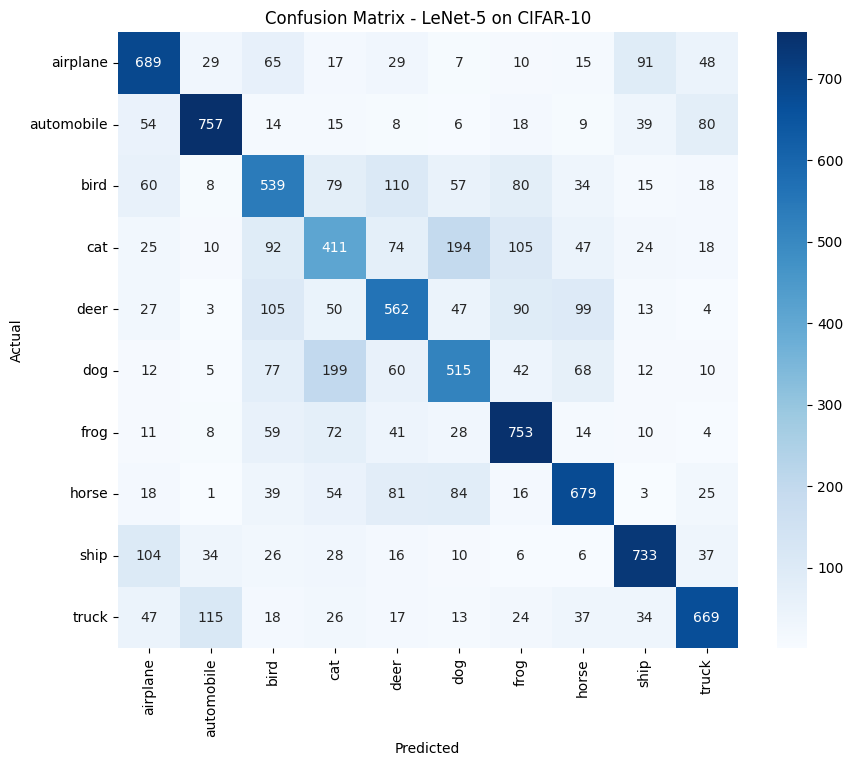

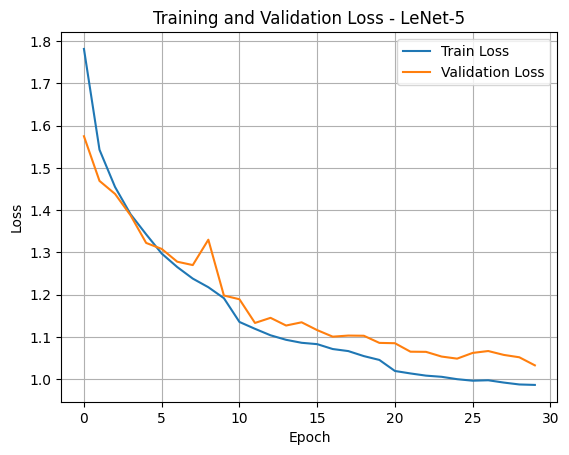

In [7]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix - LeNet-5 on CIFAR-10")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss - LeNet-5")
plt.grid()
plt.show()

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
# Binarize the labels for multiclass ROC & PR computation
n_classes = 10
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_scores = []

# Get predicted probabilities from model
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        y_scores.append(probs.cpu().numpy())

y_scores = np.vstack(y_scores)

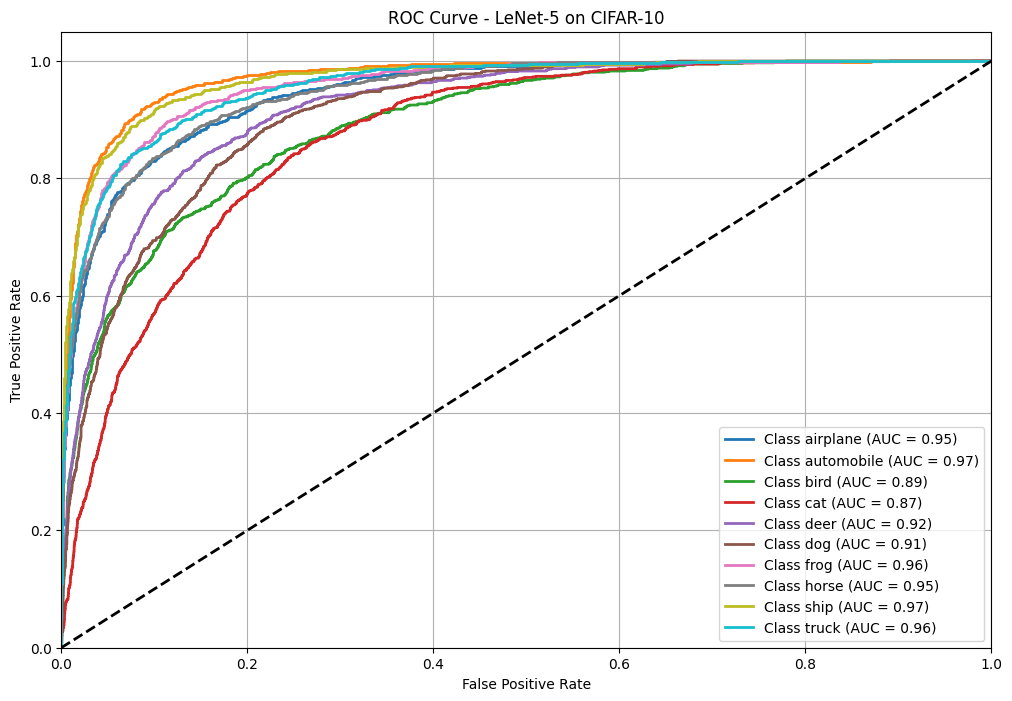

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LeNet-5 on CIFAR-10")
plt.legend(loc="lower right")
plt.grid()
plt.show()

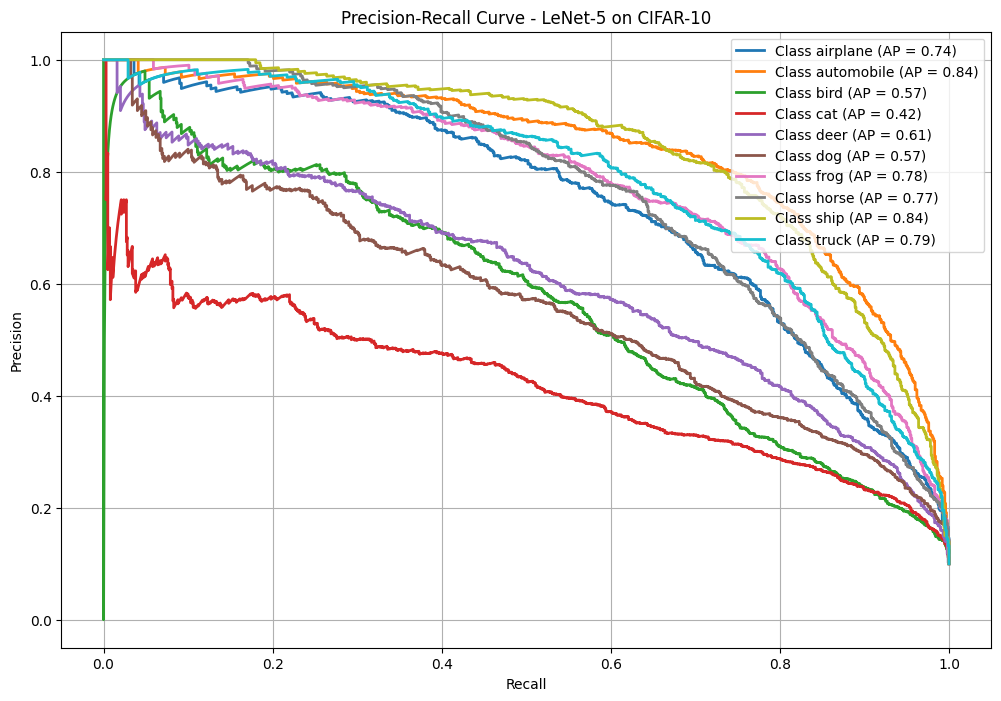

In [11]:
# Precision-Recall Curve
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])

# Plot all PR curves
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, color=colors[i],
             label=f"Class {test_dataset.classes[i]} (AP = {avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LeNet-5 on CIFAR-10")
plt.legend(loc="upper right")
plt.grid()
plt.show()